# Figure 8

Figure 8. As in Figure 2, except for MCS precipitation.

# Get analysis regions

In [1]:
from stats import get_analysis_regions

regions, region_names = get_analysis_regions()

region_names

{'EC': 'ECONUS',
 'NP': 'Northern Plains',
 'SP': 'Southern Plains',
 'MW': 'Midwest',
 'SE': 'Southeast',
 'NE': 'Northeast'}

# Create a masked version of the original data

In [2]:
import warnings
warnings.filterwarnings("ignore")

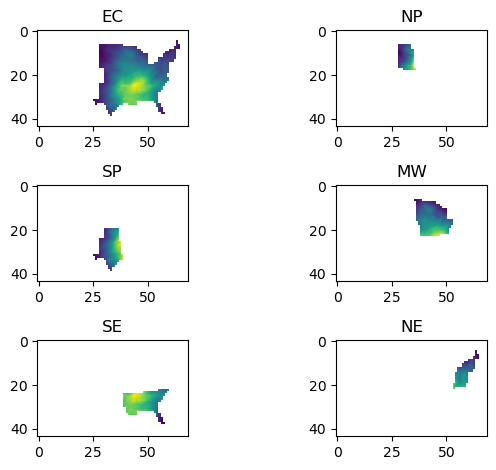

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import xarray as xr
from stats import mask_data

data_dir = "../data"
analysis='mcs_precip'
subset='annual'

show_regions = True

simulation_names = {'historical': 'HIST', 
                    'future_4p5': 'EoC 4.5',
                    'future_8p5': 'EoC 8.5'}

region_position = {'EC': 0, 'NP': 1, 'SP': 2, 
                   'MW': 3, 'SE': 4, 'NE': 5}
    
annual_years = {}

pref = "../data"

for sim in simulation_names.keys():

    annual_years[sim] = {}
        
    ds = xr.open_mfdataset(f"{data_dir}/{analysis}/{sim}_{subset}/*.nc")
    ds = ds.resample(time='AS-OCT').sum('time')

    for region_id, region_states in regions.items():

        annual_years[sim][region_id] = {}
        
        masked_data = mask_data(ds, states=region_states)
        masked_data = masked_data.compute()

        if show_regions:
            ax = plt.subplot(3, 2, region_position[region_id]+1)
    
            ax.set_title(region_id)
        
            ax.imshow(np.flipud(masked_data.mean('time')['mcs_mask'].squeeze()))

        annual_years[sim][region_id]['years_sums'] = masked_data

plt.tight_layout()

# Write out yearly means and significant differences

### Mann whitney

In [4]:
from stats import write_sig_summary

write_sig_summary(annual_years, simulation_names, regions, 'years_sums', 'mcs_mask')

  historical
    SP : 307.0404213125251
    NP : 116.05352896917918
    MW : 228.01230526497739
    SE : 403.9857115968526
    NE : 95.01588776998061
    EC : 257.9812050987332
  future_4p5
   future_4p5 - historical SP : -33.25946471712996 
   future_4p5 - historical NP : -6.912741495471309 
   future_4p5 - historical MW : 30.10185504600338 
   future_4p5 - historical SE : 51.04957340088811 
   future_4p5 - historical NE : 53.68903363021904 *
   future_4p5 - historical EC : 20.296555798191946 
  future_8p5
   future_8p5 - historical SP : -30.32551637513029 
   future_8p5 - historical NP : 17.39701851762058 
   future_8p5 - historical MW : 107.90889502195262 *
   future_8p5 - historical SE : 89.0175433517108 *
   future_8p5 - historical NE : 99.29523179454542 *
   future_8p5 - historical EC : 61.50019292799362 *


### Levene's test

In [5]:
from stats import write_sig_summary

write_sig_summary(annual_years, simulation_names, regions, 'years_sums', 'mcs_mask', test='leve')

  historical
    SP : 307.0404213125251
    NP : 116.05352896917918
    MW : 228.01230526497739
    SE : 403.9857115968526
    NE : 95.01588776998061
    EC : 257.9812050987332
  future_4p5
   future_4p5 - historical SP : -33.25946471712996 
   future_4p5 - historical NP : -6.912741495471309 
   future_4p5 - historical MW : 30.10185504600338 
   future_4p5 - historical SE : 51.04957340088811 
   future_4p5 - historical NE : 53.68903363021904 
   future_4p5 - historical EC : 20.296555798191946 
  future_8p5
   future_8p5 - historical SP : -30.32551637513029 
   future_8p5 - historical NP : 17.39701851762058 
   future_8p5 - historical MW : 107.90889502195262 
   future_8p5 - historical SE : 89.0175433517108 
   future_8p5 - historical NE : 99.29523179454542 *
   future_8p5 - historical EC : 61.50019292799362 


# Generate boxplot figure

## Set up customizations

In [6]:
#Set figure size and some fontsizes
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

#for panel labeling
import string
letters = string.ascii_lowercase
label_props = dict(boxstyle='round', facecolor='w', alpha=1)

#modify the default boxplot
meanpointprops = dict(marker='.', markeredgecolor='black',
                      markerfacecolor='black')

#What color to give each box
simulation_color_codes = {'historical': '#c7e9c0', 
                          'future_4p5': '#6baed6', 
                          'future_8p5': '#a50f15'}

#Custom legend markers
import matplotlib.lines as mlines

rc45_mark_mwu = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=8)

rc85_mark_mwu = mlines.Line2D([], [], color='k', marker='s', linestyle='None',
                          markersize=8)

## Plot boxes

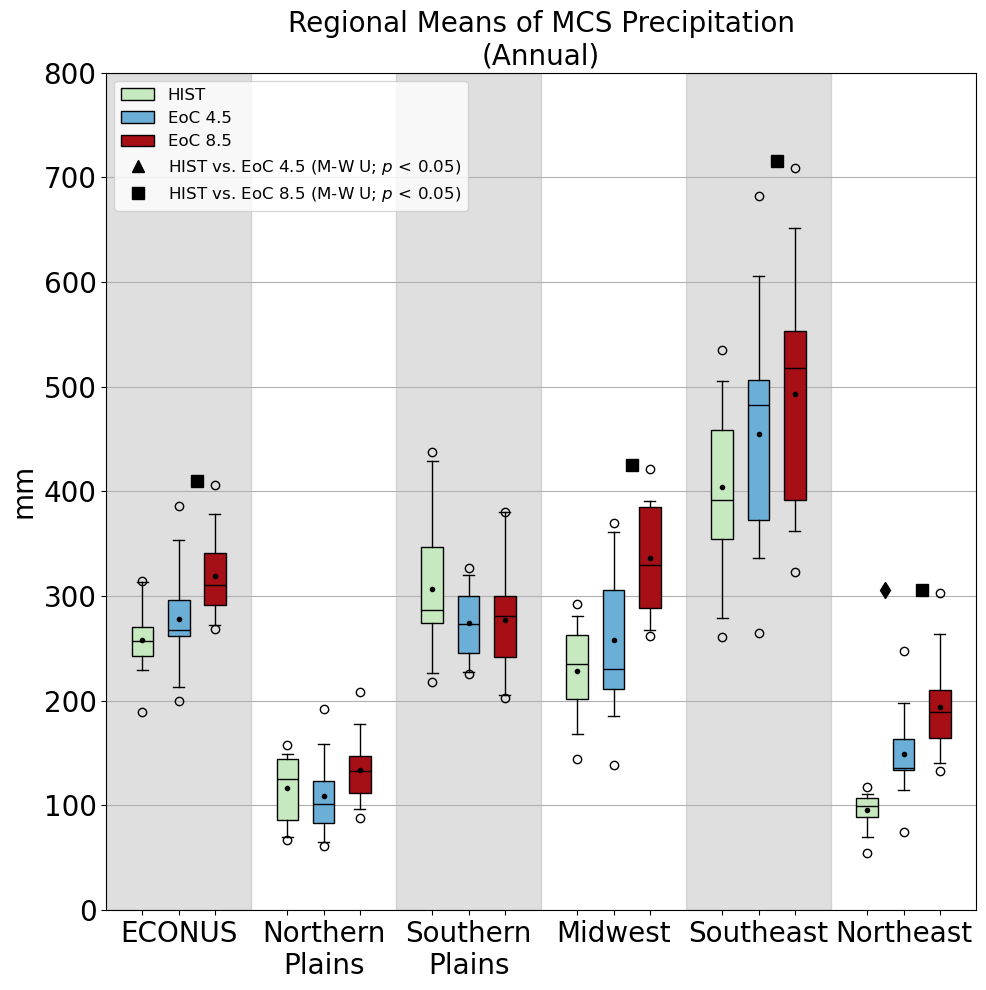

In [7]:
from scipy.stats import mannwhitneyu

ax = plt.subplot(1, 1, 1)

ax.set_title(f"Regional Means of MCS Precipitation\n(Annual)")

ax.set_xlim(-0.5, 5.5)
ax.set_ylim(0, 800)
ax.set_ylabel("mm")

ax.axvspan(-0.5, 0.5, color='grey', alpha=0.25)
ax.axvspan(1.5, 2.5, color='grey', alpha=0.25)
ax.axvspan(3.5, 4.5, color='grey', alpha=0.25)

ax.grid(axis='y')

for region_id in regions.keys():

    hist = annual_years['historical'][region_id]['years_sums']
    rcp45 = annual_years['future_4p5'][region_id]['years_sums']
    rcp85 = annual_years['future_8p5'][region_id]['years_sums']

    hist = hist.mean(('west_east', 'south_north'))['mcs_mask'].values
    rcp45 = rcp45.mean(('west_east', 'south_north'))['mcs_mask'].values
    rcp85 = rcp85.mean(('west_east', 'south_north'))['mcs_mask'].values

    rpos = region_position[region_id]

    bplot = ax.boxplot([hist, rcp45, rcp85], 
                       positions=[rpos - .25, rpos, rpos + 0.25], 
                       patch_artist=True, labels=['', region_names[region_id].replace(" ", "\n"), ''],
                       whis=[5, 95], showmeans=True, meanprops=meanpointprops)

    plt.setp(bplot['medians'], color='black')
    [item.set_color('black') for item in bplot['means']] 

    for sim, patch in zip(['historical', 'future_4p5', 'future_8p5'], bplot['boxes']):
        patch.set_facecolor(simulation_color_codes[sim])

    _, ph45 = mannwhitneyu(hist, rcp45)
    _, ph85 = mannwhitneyu(hist, rcp85)

    if ph45 < 0.05:
        m45 = ax.plot(rpos-0.125, 1.01*np.max([hist, rcp45, rcp85]), "kd", ms=8)

    if ph85 < 0.05:
        m85 = ax.plot(rpos+0.125, 1.01*np.max([hist, rcp45, rcp85]), "ks", ms=8)


ax.legend([bplot["boxes"][0], bplot["boxes"][1], bplot["boxes"][2], rc45_mark_mwu, rc85_mark_mwu],
          ['HIST', 'EoC 4.5', 'EoC 8.5', 
           r'HIST vs. EoC 4.5 (M-W U; $\mathit{p}$ < 0.05)', r'HIST vs. EoC 8.5 (M-W U; $\mathit{p}$ < 0.05)'], 
          loc='upper left', prop={'size':12}, ncol=1)  

plt.tight_layout()

#plt.savefig("Figure_8.png", dpi=200, bbox_inches='tight')